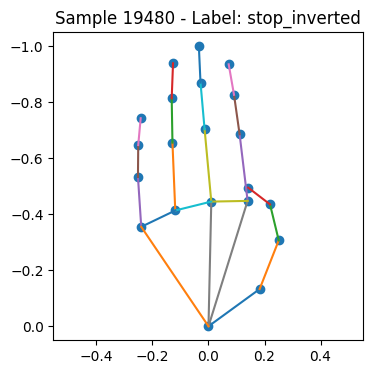

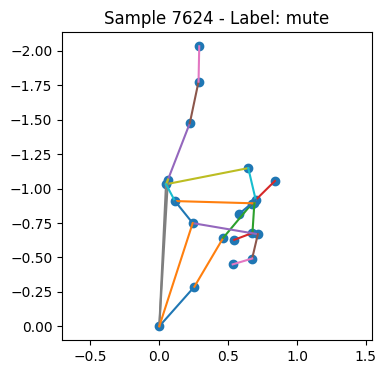

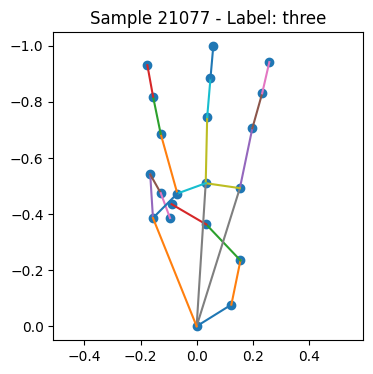

In [1]:
import sys
sys.path.append("./src")

from preprocessing import load_and_split
from visualization import plot_multiple_samples
import pandas as pd

# Load raw (not split yet for visualization)
df = pd.read_csv(r"C:\Users\Home\Desktop\hand-gesture-classification-ml1\data\hand_landmarks_data.csv")

from preprocessing import normalize_landmarks
df_norm = normalize_landmarks(df)

plot_multiple_samples(df_norm, n_samples=3)


In [2]:
import sys
sys.path.append("./src")

from preprocessing import load_and_split
from train import train_random_forest, train_svm, train_logistic_regression

X_train, X_test, y_train, y_test = load_and_split(r"C:\Users\Home\Desktop\hand-gesture-classification-ml1\data\hand_landmarks_data.csv")

# Train models in memory, debug mode for speed
rf_model = train_random_forest(X_train, y_train, debug=True)
svm_model = train_svm(X_train, y_train, debug=True)
lr_model = train_logistic_regression(X_train, y_train, debug=True)

models = {
    'RandomForest': rf_model,
    'SVM': svm_model,
    'LogisticRegression': lr_model
}

INFO:root:Training Random Forest...
INFO:root:RF best params: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}
INFO:root:Training SVM...
INFO:root:SVM best params: {'C': 10, 'gamma': 'scale'}
INFO:root:Training Logistic Regression...
INFO:root:LogReg best params: {'C': 1.0}


Evaluating RandomForest...


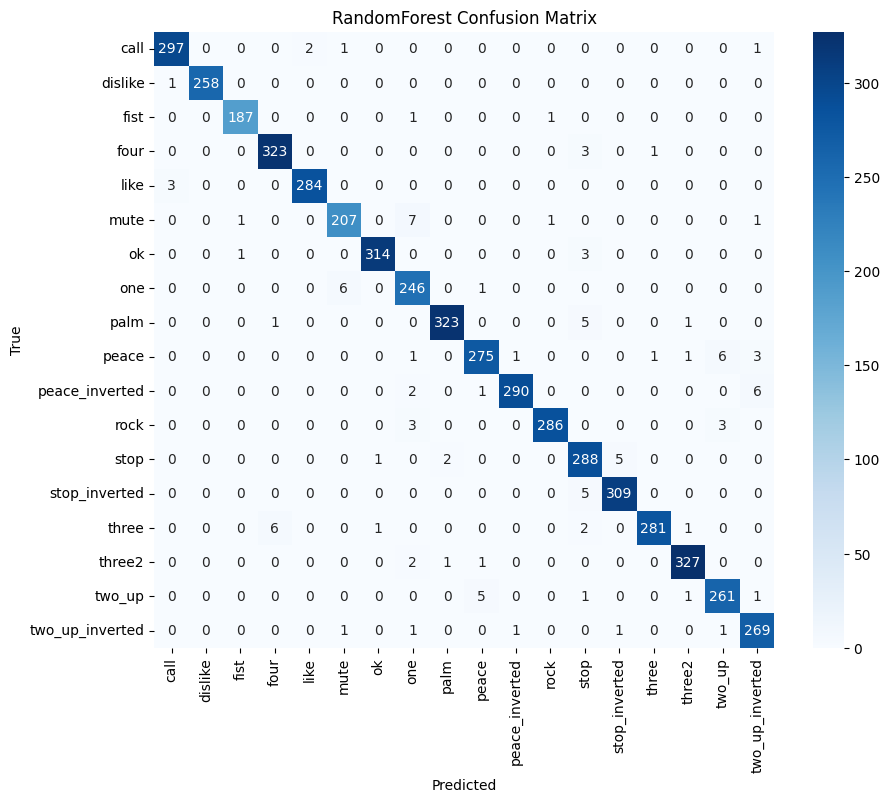

RandomForest metrics: {'accuracy': 0.9785783836416748, 'f1_score': 0.9786364127622691, 'auc': 0.999181446902672}

Evaluating SVM...


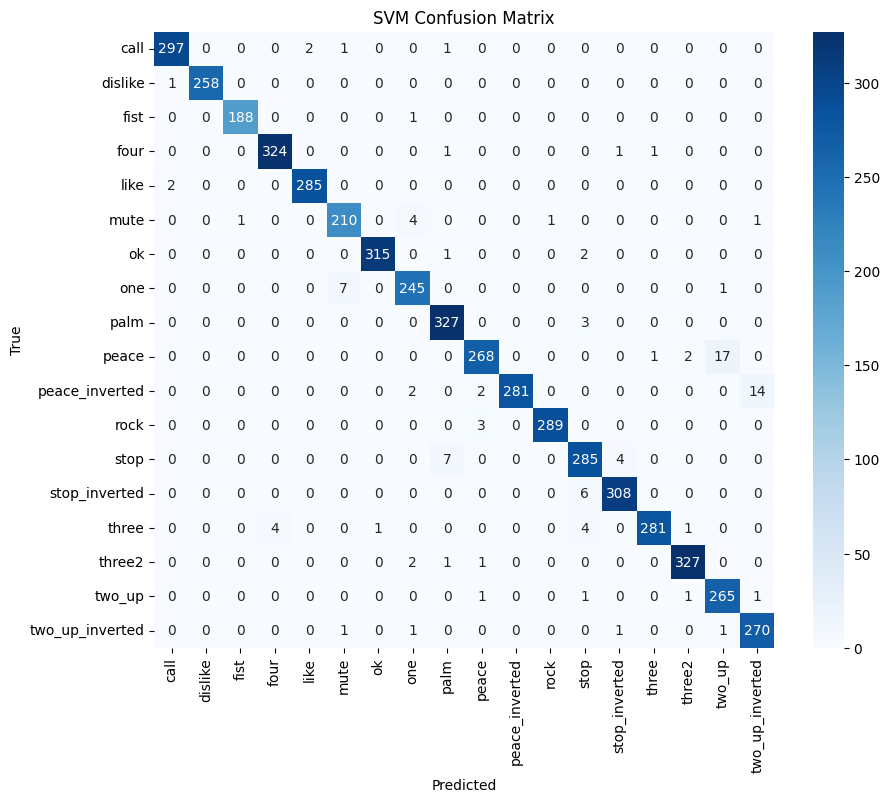

SVM metrics: {'accuracy': 0.978188899707887, 'f1_score': 0.978209535036001, 'auc': 0.9994902104432684}

Evaluating LogisticRegression...


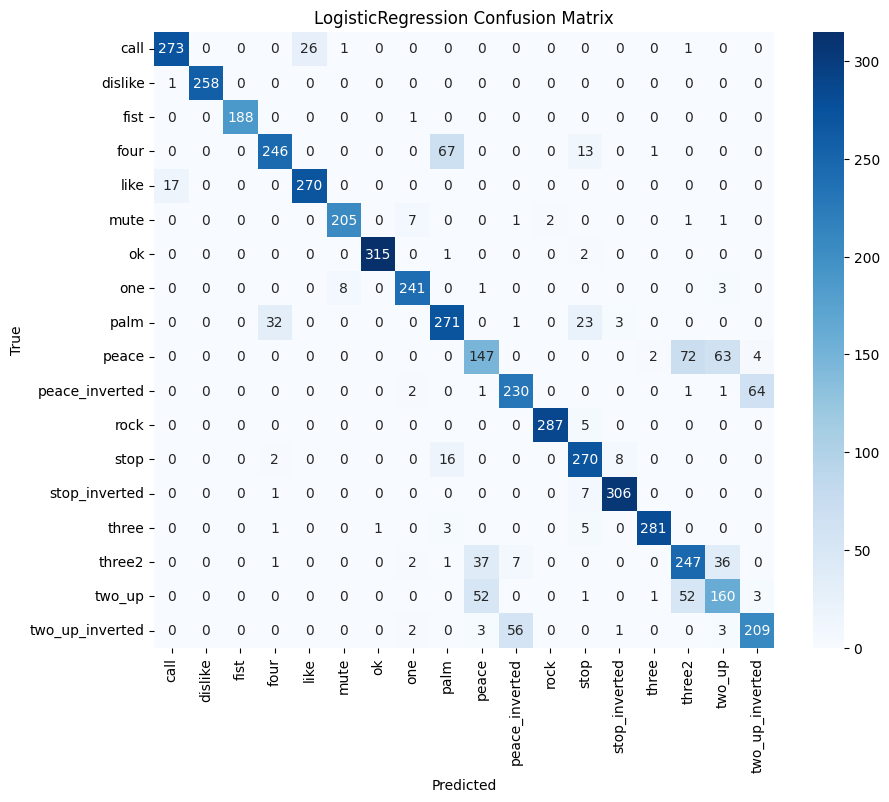

LogisticRegression metrics: {'accuracy': 0.8576436222005842, 'f1_score': 0.8569772337621292, 'auc': 0.9910309425915107}



In [3]:
import sys
sys.path.append("./src")
from evaluation import evaluate_models
labels = sorted(y_test.unique())
results = evaluate_models(models, X_test, y_test, labels)

In [ ]:
import sys
sys.path.append("./src")

from mlflow_tracking import setup_mlflow_experiment, log_model_with_mlflow
from pathlib import Path
import logging

logging.basicConfig(level=logging.INFO)

# Create output directory for artifacts
output_dir = Path("mlflow_artifacts")
output_dir.mkdir(exist_ok=True)

# Setup MLflow experiment
exp_id = setup_mlflow_experiment("hand-gesture-classification")
print(f"MLflow Experiment ID: {exp_id}")

# Log each model to MLflow
for model_name, model in models.items():
    log_model_with_mlflow(model, X_test, y_test, model_name, exp_id, output_dir)
    print(f"Logged {model_name} to MLflow")


MLflow Experiment ID: 1


INFO:root:Logging RandomForest to MLflow...


🏃 View run RandomForest_trial_0 at: http://localhost:5000/#/experiments/1/runs/4a3ce0c8a1bd46559dbdcf3a14ad5f1f
🧪 View experiment at: http://localhost:5000/#/experiments/1


C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive 

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter

# Ensemble voting - combine predictions from all 3 models
def ensemble_vote(models, X_test):
    """
    Get predictions from all models and return majority vote
    """
    predictions = []
    for name, model in models.items():
        pred = model.predict(X_test)
        predictions.append(pred)
    
    # Stack predictions and get majority vote
    predictions = np.array(predictions)
    ensemble_pred = np.zeros(X_test.shape[0], dtype=object)
    
    for i in range(X_test.shape[0]):
        # Get the most common prediction using Counter
        votes = predictions[:, i]
        most_common = Counter(votes).most_common(1)[0][0]
        ensemble_pred[i] = most_common
    
    return ensemble_pred

# Get ensemble predictions
ensemble_predictions = ensemble_vote(models, X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

print(f"\nEnsemble (Voting) Results:")
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Compare with individual models
print(f"\nIndividual Model Comparison:")
print(f"RandomForest:       {results['RandomForest']['accuracy']:.4f}")
print(f"SVM:                {results['SVM']['accuracy']:.4f}")
print(f"LogisticRegression: {results['LogisticRegression']['accuracy']:.4f}")
print(f"Ensemble Vote:      {ensemble_accuracy:.4f}")



Ensemble (Voting) Results:
Ensemble Accuracy: 0.9764

Individual Model Comparison:
RandomForest:       0.9786
SVM:                0.9782
LogisticRegression: 0.8576
Ensemble Vote:      0.9764
